In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lattice_afi import lattice_2d
from krylov_trotter_circuits import HeavyHexHeisenbergKrylovTNSim
import numpy as np
from scipy.sparse import kron as spkron
from scipy.sparse.linalg import expm as sp_expm
from scipy.linalg import toeplitz
# from krylov_ED.ED_Kylov_trotter import solve_regularized_gen_eig

In [3]:
import scipy as sp
import itertools as it
from qiskit.quantum_info import Pauli

def solve_regularized_gen_eig(h, s, k=1, threshold=1e-15, return_vecs=False):

    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
    if not good_vecs:
        raise AssertionError('WHOLE SUBSPACE ILL-CONDITIONED')
    good_vecs = np.array(good_vecs).T

    h_reg = good_vecs.conj().T @ h @ good_vecs
    s_reg = good_vecs.conj().T @ s @ good_vecs
    vals, vecs = sp.linalg.eigh(h_reg, s_reg)
    if return_vecs:
        return vals[0:k], good_vecs @ vecs[:,0:k]
    else:
        return vals[0:k]
    
def single_particle_gs(H_op, n_qubits):
    H_x = []
    for p, coeff in H_op.to_list():
        H_x.append(set([i for i,v in enumerate(Pauli(p).x) if v]))

    H_z = []
    for p, coeff in H_op.to_list():
        H_z.append(set([i for i,v in enumerate(Pauli(p).z) if v]))

    H_c = H_op.coeffs

    print('n_sys_qubits', n_qubits)

    # n_exc particle Hamiltonian:

    n_exc = 1
    sub_dimn = int(sp.special.comb(n_qubits+1,n_exc))
    print('n_exc', n_exc, ', subspace dimension', sub_dimn)

    few_particle_H = np.zeros((sub_dimn,sub_dimn), dtype=complex)

    sparse_vecs = [set(vec) for vec in it.combinations(range(n_qubits+1),r=n_exc)] # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

    m = 0
    for i, i_set in enumerate(sparse_vecs):
        for j, j_set in enumerate(sparse_vecs):
            m += 1
            # if m % int((sub_dimn**2)/100) == 0:
            #     print(np.round(m/int((sub_dimn**2)/100),2), '% complete, time =', time.time()-start_time)
            #     start_time = time.time()

            if len(i_set.symmetric_difference(j_set)) <= 2:

                for p_x, p_z, coeff in zip(H_x, H_z, H_c):

                    if i_set.symmetric_difference(j_set) == p_x:
                        sgn = ((-1j)**len(p_x.intersection(p_z)))*((-1)**len(i_set.intersection(p_z)))
                    else:
                        sgn = 0

                    few_particle_H[i,j] += sgn*coeff

    gs_en = min(np.linalg.eigvalsh(few_particle_H))
    print('single particle ground state energy: ', gs_en)
    return gs_en


# def krylov_diagonalization(Hkrylov, Skrylov, k=1, initial_threshold = 1e-15):
#     success = False
#     threshold = initial_threshold
#     count = 0
#     while not success and count < 16:
#         try:
#             evals = solve_regularized_gen_eig(Hkrylov, Skrylov, threshold=threshold, k=k)
#             success = True
#         except:
#             threshold *= 10
#             count += 1
#     if not success:
#         print('Did not converge')
#     return evals, threshold

# def spectral_norm(H):
#     sing_max = -np.inf
#     for h in H:
#         u,s,vh = np.linalg.svd(h.toarray(), full_matrices=False)
#         if max(s) > sing_max:
#             sing_max = max(s)
#     return sing_max

## Small system example

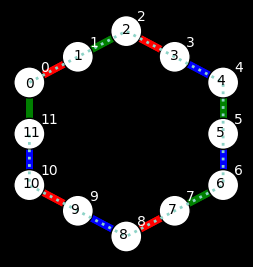

In [4]:
#Example lattice
n_qubits = 12
mps_order = np.arange(n_qubits) #Do not need to set manually always. The default is optimized for a 2D heavy-hex lattice. 
                        #In this example, we consider a single plaquette so that the TN numerics can be benchmarked against exact calculations.
lat = lattice_2d(nx=1,ny=1, mps_order=mps_order) #Initialize lattice
lat.draw(show_gates=True, show_mps_order=True, enumerate_qubits=True)

In [5]:
edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1]]
l1_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==1]
l2_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==2]
l3_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==3]
colored_edges = [l1_edges, l2_edges, l3_edges]

In [6]:
#Krylov algorithms parameters

dt = 0.1
trotter_order = 6
krylov_dim = 10

J = 1.0
g = -1.0

particle_inds = [int(n_qubits/2)]

In [7]:
from qiskit.quantum_info import SparsePauliOp
# Define the Hamiltonian: 
H_int = [['I']*n_qubits for _ in range(3*(n_qubits))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
# boundary conditions
H_int[n_qubits-1][0] = 'Z'
H_int[n_qubits-1][-1] = 'Z'

for i in range(n_qubits-1):
    H_int[n_qubits+i][i] = 'X'
    H_int[n_qubits+i][i+1] = 'X'
# boundary conditions
H_int[2*n_qubits-1][0] = 'X'
H_int[2*n_qubits-1][-1] = 'X'

for i in range(n_qubits-1):
    H_int[2*(n_qubits)+i][i] = 'Y'
    H_int[2*(n_qubits)+i][i+1] = 'Y'
# boundary conditions
H_int[3*n_qubits-1][0] = 'Y'
H_int[3*n_qubits-1][-1] = 'Y'


H_int = [''.join(term) for term in H_int]
H_tot = [(term, g) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIIIIIIIIII', -1.0), ('IZZIIIIIIIII', -1.0), ('IIZZIIIIIIII', -1.0), ('IIIZZIIIIIII', -1.0), ('IIIIZZIIIIII', -1.0), ('IIIIIZZIIIII', -1.0), ('IIIIIIZZIIII', -1.0), ('IIIIIIIZZIII', -1.0), ('IIIIIIIIZZII', -1.0), ('IIIIIIIIIZZI', -1.0), ('IIIIIIIIIIZZ', -1.0), ('ZIIIIIIIIIIZ', -1.0), ('XXIIIIIIIIII', 1), ('IXXIIIIIIIII', 1), ('IIXXIIIIIIII', 1), ('IIIXXIIIIIII', 1), ('IIIIXXIIIIII', 1), ('IIIIIXXIIIII', 1), ('IIIIIIXXIIII', 1), ('IIIIIIIXXIII', 1), ('IIIIIIIIXXII', 1), ('IIIIIIIIIXXI', 1), ('IIIIIIIIIIXX', 1), ('XIIIIIIIIIIX', 1), ('YYIIIIIIIIII', 1), ('IYYIIIIIIIII', 1), ('IIYYIIIIIIII', 1), ('IIIYYIIIIIII', 1), ('IIIIYYIIIIII', 1), ('IIIIIYYIIIII', 1), ('IIIIIIYYIIII', 1), ('IIIIIIIYYIII', 1), ('IIIIIIIIYYII', 1), ('IIIIIIIIIYYI', 1), ('IIIIIIIIIIYY', 1), ('YIIIIIIIIIIY', 1)]


In [8]:
tn_circ = HeavyHexHeisenbergKrylovTNSim(lat.nx, lat.ny, chi_max=64, J=J, g=g, mps_order=mps_order) #change lat.nx and lat.ny appropriately. chi_max is maximum bond dimension
tn_circ.initialize_state(flip_inds=particle_inds) #lattice site indices to populate with a particle
S_tn = tn_circ.krylov_S(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order) #Build H and S matrices
H_tn = tn_circ.krylov_H(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order)

In [9]:
gs_en = single_particle_gs(H_op, n_qubits)
gs_en

n_sys_qubits 12
n_exc 1 , subspace dimension 13
single particle ground state energy:  -12.0


-12.0

In [10]:
gs_en = min(sp.sparse.linalg.eigsh(H_op.to_matrix(), which = "SA", k = 10)[0])
print('gs_en', gs_en)

gs_en -12.0


In [11]:
gnd_en_tn_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_tn_est = solve_regularized_gen_eig(H_tn[:d, :d], S_tn[:d, :d], threshold=0.01)
    gnd_en_tn_list.append(gnd_en_tn_est)
    print('The estimated ground state energy is: ', gnd_en_tn_est)

The estimated ground state energy is:  [-8.]
The estimated ground state energy is:  [-10.6521752]
The estimated ground state energy is:  [-10.70921443]
The estimated ground state energy is:  [-10.70324426]
The estimated ground state energy is:  [-11.16493628]
The estimated ground state energy is:  [-11.2461311]
The estimated ground state energy is:  [-11.2833081]
The estimated ground state energy is:  [-11.29546004]
The estimated ground state energy is:  [-11.29242717]
The estimated ground state energy is:  [-11.43718883]


## Noiseless circuit simulator

### Alternative circuit constructions

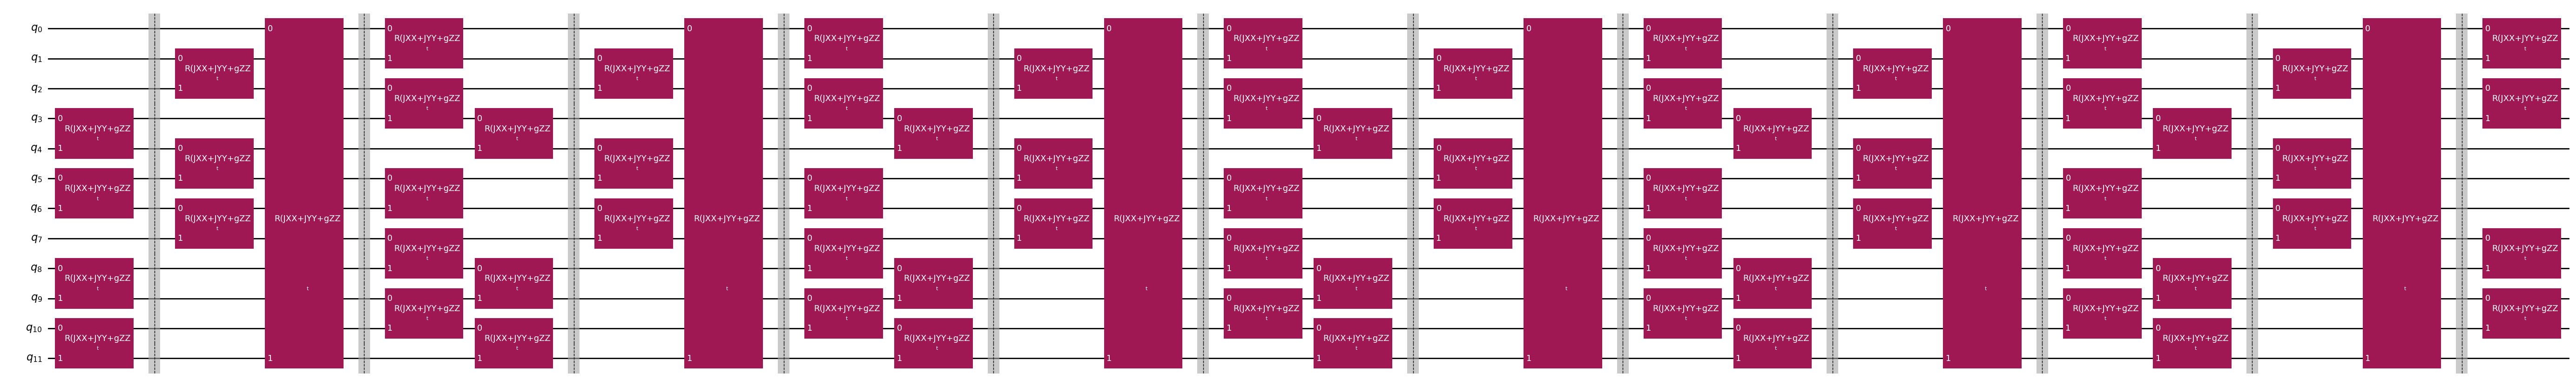

In [67]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile

barriers=True
interaction_list = []
for l in range(3):
    layer = []
    # print(colored_edges[l])
    for e in colored_edges[l]:
        layer.append([e[0]-1, e[1]-1])
    interaction_list.append(layer)

t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
# R??(param) rotations are exp(-1j*??*param/2)
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(2*J*t,0,1)
Rxyz_circ.ryy(2*J*t,0,1)
Rxyz_circ.rzz(2*g*t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='R(JXX+JYY+gZZ')


trotter_step_circ = QuantumCircuit(n_qubits)

qubit_order = list(range(n_qubits))

# Interact all neighboring qubits, so iterate over the colors in the coloring specified by interaction_list:
hamiltonian_interactions_local = []
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
        hamiltonian_interactions_local.append(tuple(sorted([qubit_order[interaction[0]], qubit_order[interaction[1]]])))

    if barriers and i < len(interaction_list)-1:
        trotter_step_circ.barrier()

reverse_trotter_step_circ = trotter_step_circ.reverse_ops()


trotter_circ = QuantumCircuit(n_qubits)

for step in range(trotter_order):
    if step % 2 == 0:
        trotter_circ = trotter_circ.compose(trotter_step_circ)
    else:
        # trotter_circ = trotter_circ.compose(reverse_trotter_step_circ)
        trotter_circ = trotter_circ.compose(trotter_step_circ)


trotter_circ.draw('mpl', fold=-1)


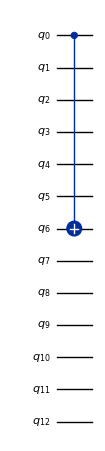

In [68]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(0,int(n_qubits/2))
controlled_state_prep.draw('mpl', fold=-1, scale=0.5)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

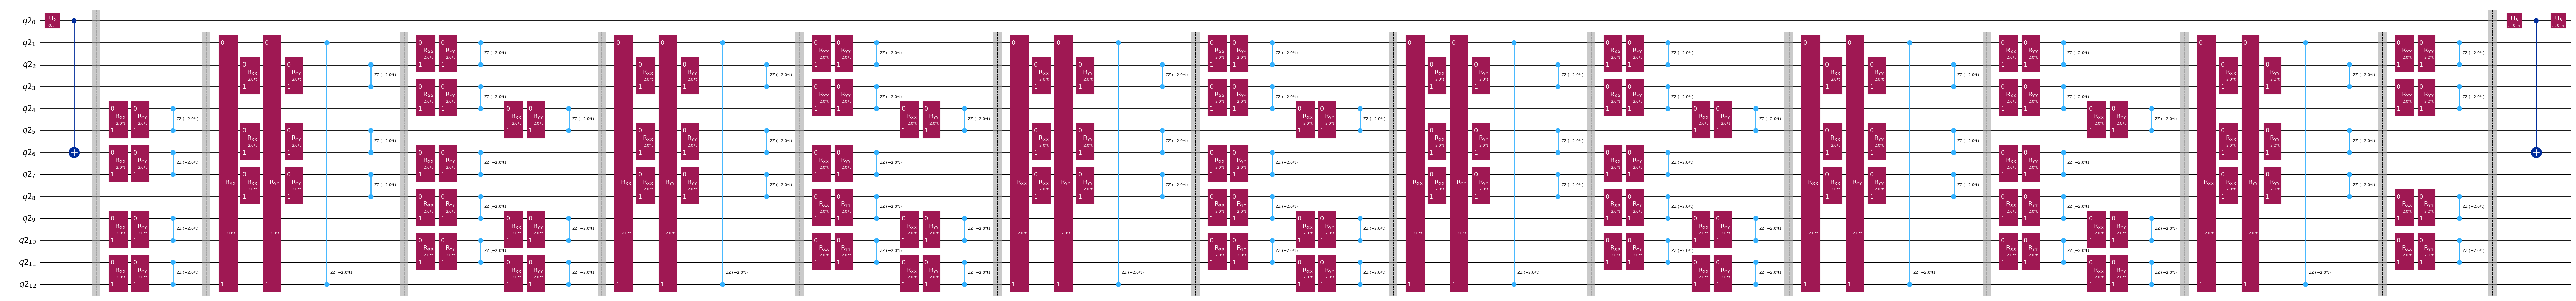

In [69]:
# Create hadamard test circuit
qr = QuantumRegister(n_qubits+1)
qc = QuantumCircuit(qr)
qc.h(0)
qc.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc.barrier()
qc.compose(trotter_circ, list(range(1, n_qubits+1)), inplace=True)
qc.barrier()
qc.x(0)
qc.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc.x(0)

qc.decompose().draw('mpl', fold=-1)

In [70]:
# Parameters for the template circuits
dt_circ = dt/trotter_order
parameters = []
for idx_ket in range(1, krylov_dim):
    parameters.append(dt_circ*(idx_ket))



# Define a sweep over parameter values
params = np.vstack(parameters).T

In [71]:
params

array([[0.01666667, 0.03333333, 0.05      , 0.06666667, 0.08333333,
        0.1       , 0.11666667, 0.13333333, 0.15      ]])

In [72]:
from qiskit.quantum_info import StabilizerState, Pauli



qc_cliff = qc.assign_parameters({t:0})

# observables_H_real_cliff = []
# observables_H_imag_cliff = []
# for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
#     # print(pauli)
#     observable_real = pauli[::-1].to_label() + 'X'
#     observable_imag = pauli[::-1].to_label() + 'Y'
#     observables_H_real_cliff.append(observable_real)
#     observables_H_imag_cliff.append(observable_imag)



# Get expectation values from experiment
S_expval_real = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'X'))
S_expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Y'))

# Get expectation values
S_expval = S_expval_real + 1j*S_expval_imag

H_expval = 0
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Get expectation values from experiment
    expval_real = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'X'))
    expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'Y'))
    expval = expval_real + 1j*expval_imag


    # Fill-in matrix elements
    H_expval += coeff*expval


H_expval

(-8+0j)

In [73]:
# These are the phases picked up by the all-zeros state under the various Trotter evolutions.
relative_phases = [np.exp(-1j*sum([c for p,c in H_op.to_list() if 'Z' in p])*i*dt) for i in range(1, krylov_dim)]
print(relative_phases)

[(0.3623577544766734+0.9320390859672264j), (-0.7373937155412458+0.6754631805511506j), (-0.896758416334147-0.44252044329485246j), (0.08749898343944729-0.9961646088358406j), (0.9601702866503661-0.27941549819892586j), (0.6083513145322546+0.7936678638491531j), (-0.5192886541166856+0.8545989080882805j), (-0.9846878557941267-0.1743267812229814j), (-0.1943299064553348-0.9809362300664916j)]


In [26]:
dt

0.1

In [30]:
# prefactors = []
# E0t_array = []
# for i, circ in enumerate(iter(qc.assign_parameters([(i*dt)/trotter_order]) for i in range(1, krylov_dim+1))):
#     phase = 1.0
#     E0t = 0
#     for instruction in circ.data:
#         if instruction.operation.name != 'swap' and instruction.operation.name != 'barrier':
#             # All the non-swap gates are XX+YY+ZZ rotations, which add a phase to the all-zeros state.
#             if instruction.operation.params:
#                 E0t += float(instruction.operation.params[0])
#                 print(instruction.operation.params[0])
#                 # phase *= np.exp(1j*float(instruction.operation.params[0])/2)
#                 phase *= np.exp(-1j*float(instruction.operation.params[0])/2) # NY added, we need to `subtract` the E0 * t so minus sign
#             # assert(float(instruction.operation.params[0]._symbol_expr) == i*dt/n_T_step)
#     prefactors.append(phase)
# prefactors

In [51]:
parameters

[0.016666666666666666,
 0.03333333333333333,
 0.05,
 0.06666666666666667,
 0.08333333333333333,
 0.1,
 0.11666666666666667,
 0.13333333333333333,
 0.15]

In [52]:
dt/trotter_order

0.016666666666666666

In [74]:
from qiskit.quantum_info import Statevector, Pauli
import itertools

H_first_row_sim = np.zeros(krylov_dim, dtype=complex)
H_first_row_sim[0] = H_expval

S_first_row_sim = np.zeros(krylov_dim, dtype=complex)
S_first_row_sim[0] = 1+0j

all_exp_vals_sim = []
for i, param in enumerate(parameters):
    print(param)
    qc_param = qc.assign_parameters({t:param})

    observables_H_real, observables_H_imag = [], []
    for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
        # print(pauli)
        observable = pauli[::-1].to_label() + 'X'
        observables_H_real.append(observable)
        
        observable = pauli[::-1].to_label() + 'Y'
        observables_H_imag.append(observable)



    # Get expectation values from experiment
    S_expval_real = Statevector(qc_param).expectation_value(Pauli('I'*(n_qubits) + 'X'))
    S_expval_imag = Statevector(qc_param).expectation_value(Pauli('I'*(n_qubits) + 'Y'))

    # Get expectation values
    S_expval = S_expval_real + 1j*S_expval_imag

    S_first_row_sim[i+1] += relative_phases[i]*S_expval


    res_dict_sim = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        expval_real = Statevector(qc_param).expectation_value(Pauli(observables_H_real[obs_idx]))
        expval_imag = Statevector(qc_param).expectation_value(Pauli(observables_H_imag[obs_idx]))

        res_dict_sim[observables_H_real[obs_idx]] = expval_real
        res_dict_sim[observables_H_imag[obs_idx]] = expval_imag


        expval = expval_real + 1j*expval_imag


        H_first_row_sim[i+1] += relative_phases[i]*coeff*expval

    all_exp_vals_sim.append(res_dict_sim)


H_first_row_sim_list = H_first_row_sim.tolist()           
            
H_eff_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_sim[j,i] = H_first_row_sim[i-j]
    else:
        H_eff_circ_sim[j,i] = np.conj(H_first_row_sim[j-i])

            
            
S_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ_sim[j,i] = S_first_row_sim[i-j]
    else:
        S_circ_sim[j,i] = np.conj(S_first_row_sim[j-i])


0.016666666666666666
0.03333333333333333
0.05
0.06666666666666667
0.08333333333333333
0.1
0.11666666666666667
0.13333333333333333
0.15


In [75]:
Matrix(abs(S_circ_sim))

Matrix([
[                1.0,   0.960401881768092,    0.84634354730388,   0.671398679249907, 0.456165350586377, 0.225530278291871, 0.00539605762168556,   0.180670385387948,    0.31440367458709,   0.385016521520941],
[  0.960401881768092,                 1.0,   0.960401881768092,    0.84634354730388, 0.671398679249907, 0.456165350586377,   0.225530278291871, 0.00539605762168556,   0.180670385387948,    0.31440367458709],
[   0.84634354730388,   0.960401881768092,                 1.0,   0.960401881768092,  0.84634354730388, 0.671398679249907,   0.456165350586377,   0.225530278291871, 0.00539605762168556,   0.180670385387948],
[  0.671398679249907,    0.84634354730388,   0.960401881768092,                 1.0, 0.960401881768092,  0.84634354730388,   0.671398679249907,   0.456165350586377,   0.225530278291871, 0.00539605762168556],
[  0.456165350586377,   0.671398679249907,    0.84634354730388,   0.960401881768092,               1.0, 0.960401881768092,    0.84634354730388,   0.67139867924

In [64]:
Matrix(abs(S_kry))

Matrix([
[                1.0,   0.960398226659564,    0.84628735275055,   0.671132744273203, 0.455402167912501, 0.223890783006626, 0.00250771660683511,   0.185035829944304,    0.32018720583263,   0.391765227592589],
[  0.960398226659564,                 1.0,   0.960398226659564,   0.846287352750549, 0.671132744273203, 0.455402167912501,   0.223890783006626, 0.00250771660683508,   0.185035829944304,    0.32018720583263],
[   0.84628735275055,   0.960398226659564,                 1.0,   0.960398226659564,  0.84628735275055, 0.671132744273203,   0.455402167912501,   0.223890783006626, 0.00250771660683513,   0.185035829944304],
[  0.671132744273203,   0.846287352750549,   0.960398226659564,                 1.0, 0.960398226659564, 0.846287352750549,   0.671132744273203,   0.455402167912501,   0.223890783006626, 0.00250771660683513],
[  0.455402167912501,   0.671132744273203,    0.84628735275055,   0.960398226659564,               1.0, 0.960398226659564,    0.84628735275055,   0.67113274427

In [81]:
Matrix(S_circ_sim)

Matrix([
[                                         1.0,      0.669118434697473 + 0.688950139597704*I,     -0.024712827284038 + 0.845982668989468*I,      -0.49508516669988 + 0.453505087305832*I, -0.455387486394947 - 0.0266282614994728*I,  -0.147416429077416 - 0.170681876203866*I, 0.000472131242949334 - 0.00537536323851532*I,     -0.140121867778492 + 0.114051086476615*I,    -0.312260907626688 - 0.0366441831948994*I,     -0.234222948049358 - 0.305577048305584*I],
[     0.669118434697473 - 0.688950139597704*I,                                          1.0,      0.669118434697473 + 0.688950139597704*I,     -0.024712827284038 + 0.845982668989468*I,   -0.49508516669988 + 0.453505087305832*I, -0.455387486394947 - 0.0266282614994728*I,     -0.147416429077416 - 0.170681876203866*I, 0.000472131242949334 - 0.00537536323851532*I,     -0.140121867778492 + 0.114051086476615*I,    -0.312260907626688 - 0.0366441831948994*I],
[    -0.024712827284038 - 0.845982668989468*I,      0.669118434697473 - 0.68895

In [82]:
Matrix(S_kry)

Matrix([
[                                         1.0,      0.669115888158838 + 0.688947517583338*I,    -0.0247111864299384 + 0.845926498397324*I,        -0.49488906792101 + 0.4533254580188*I, -0.454625605112655 - 0.0265837114669554*I,    -0.14634478208244 - 0.16944110325586*I, 0.000219422653852551 - 0.00249809853271901*I,     -0.143507476006627 + 0.116806946254856*I,    -0.318005104012294 - 0.0373175642430941*I,     -0.238330891193979 - 0.310931471313787*I],
[     0.669115888158838 - 0.688947517583338*I,                                          1.0,      0.669115888158838 + 0.688947517583339*I,    -0.0247111864299385 + 0.845926498397324*I,     -0.49488906792101 + 0.4533254580188*I, -0.454625605112655 - 0.0265837114669554*I,       -0.14634478208244 - 0.16944110325586*I, 0.000219422653852556 - 0.00249809853271898*I,     -0.143507476006627 + 0.116806946254856*I,    -0.318005104012294 - 0.0373175642430942*I],
[   -0.0247111864299384 - 0.845926498397324*I,      0.669115888158838 - 0.68894

In [76]:


gnd_en_kry_est_list = []
for d in range(1, d+1):
    # Solve generalized eigenvalue problem
    gnd_en_kry_est = solve_regularized_gen_eig(H_kry[:d, :d], S_kry[:d, :d], threshold=1e-8)
    gnd_en_kry_est_list.append(gnd_en_kry_est)
    print('The estimated ground state energy is: ', gnd_en_kry_est)

The estimated ground state energy is:  [-8.]
The estimated ground state energy is:  [-10.8141386]
The estimated ground state energy is:  [-11.45628441]
The estimated ground state energy is:  [-11.69093143]
The estimated ground state energy is:  [-11.80129412]
The estimated ground state energy is:  [-11.79948968]
The estimated ground state energy is:  [-11.797348]
The estimated ground state energy is:  [-11.85519746]
The estimated ground state energy is:  [-11.85248509]
The estimated ground state energy is:  [-12.00000001]


## Exact Krylov

In [20]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

def tensor(op_list):
    op = op_list[0]
    for i in range(1, len(op_list)):
        op = spkron(op, op_list[i], format='csr')
    return op


zero, one = np.array([1,0]), np.array([0,1])
X,Y,Z,I= np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]]), np.eye(2)
H = np.sqrt(1/2)*np.array([[1,1],[1,-1]])

# Make it sparse and calculate true GS
H_mat = H_op.to_matrix(sparse=True)
true_gse, true_gs = sp.sparse.linalg.eigsh(H_mat, which='SA', k=1)
true_gse = true_gse[0]


d = krylov_dim # Krylov dimension

# # start with computational state as reference state
# checkerboard_excitations = [l*r + i for r in range(w) for i in range(l) if i%2==r%2]
# v0 = np.zeros(2**n_qubits, dtype=complex)
# v0[sum([2**q for q in checkerboard_excitations])] = 1
particle_inds_ED = np.array(particle_inds) - 1
# psi_sys = tensor([zero for idx in range(lat.n_qubits)])
psi_sys = tensor([zero if idx in particle_inds_ED else one for idx in range(lat.n_qubits)])
v0 = psi_sys.T


# Construct Krylov vectors
v = [v0.toarray()]
for i in range(d-1):
    ui = sp.sparse.linalg.expm_multiply(-1j*H_mat*dt, v[i])
    ui = ui/np.linalg.norm(ui)
    v.append(ui)

v = np.array(v).T

# Construct Krylov matrices
H_kry = np.conj(v[0]).T @ H_mat @ v[0]
S_kry = np.conj(v[0]).T @ v[0]


gnd_en_kry_est_list = []
for d in range(1, d+1):
    # Solve generalized eigenvalue problem
    gnd_en_kry_est = solve_regularized_gen_eig(H_kry[:d, :d], S_kry[:d, :d], threshold=0.003)
    gnd_en_kry_est_list.append(gnd_en_kry_est)
    print('The estimated ground state energy is: ', gnd_en_kry_est)

# # Look at all subspace dimensions up to d
# approx_gs_energies = []
# for _d in range(1,d+1):

# 	# Regularize by projecting onto good eigenspaces of S_kry
# 	s_vals, s_vecs = sp.linalg.eigh(S_kry[:_d,:_d])
# 	s_vecs = s_vecs.T
# 	reg_transform = [vec for val, vec in zip(s_vals, s_vecs) if val > _d * threshold_rescale * r]
# 	if reg_transform is []:
# 		raise AssertionError('WHOLE SUBSPACE ILL-CONDITIONED')
# 	reg_transform = np.array(reg_transform).T
# 	H_reg = reg_transform.T.conj() @ H_kry[:_d,:_d] @ reg_transform
# 	S_reg = reg_transform.T.conj() @ S_kry[:_d,:_d] @ reg_transform

# 	# Solve generalized eigenvalue problem
# 	vals, vecs = sp.linalg.eigh(H_reg, S_reg)

# 	approx_gs_energies.append(min(vals))

The estimated ground state energy is:  [-8.]
The estimated ground state energy is:  [-10.8141386]
The estimated ground state energy is:  [-10.79042494]
The estimated ground state energy is:  [-11.44791484]
The estimated ground state energy is:  [-11.4369287]
The estimated ground state energy is:  [-11.42316223]
The estimated ground state energy is:  [-11.40642427]
The estimated ground state energy is:  [-11.38650649]
The estimated ground state energy is:  [-11.66329469]
The estimated ground state energy is:  [-11.65450927]


In [50]:
dt

0.1

In [77]:
from sympy import Matrix
Matrix(abs(H_kry/H_eff_circ_sim))

Matrix([
[              1.0, 0.999998142507921,   0.9999702075719, 0.999853817475853, 0.999630331407607,  1.00013451832796,  1.00659830805678,   1.0158832215505,  1.01750599192247,  1.01749753219146],
[0.999998142507921,               1.0, 0.999998142507921, 0.999970207571899, 0.999853817475853, 0.999630331407607,  1.00013451832796,  1.00659830805678,   1.0158832215505,  1.01750599192247],
[  0.9999702075719, 0.999998142507921,               1.0, 0.999998142507921,   0.9999702075719, 0.999853817475853, 0.999630331407607,  1.00013451832796,  1.00659830805678,   1.0158832215505],
[0.999853817475853, 0.999970207571899, 0.999998142507921,               1.0, 0.999998142507921, 0.999970207571899, 0.999853817475853, 0.999630331407607,  1.00013451832796,  1.00659830805678],
[0.999630331407607, 0.999853817475853,   0.9999702075719, 0.999998142507921,               1.0, 0.999998142507921, 0.999970207571899, 0.999853817475853, 0.999630331407607,  1.00013451832795],
[ 1.00013451832796, 0.999630331

In [78]:
Matrix(abs(H_kry/H_tn))

Matrix([
[              1.0, 0.998343823555363,  0.99672720225691, 0.995296940059603, 0.994772311860422, 0.998473471102691,  1.01404959099674,   1.0193989473054,  1.01019324288392,  1.00299418314752],
[0.998343823555363,               1.0, 0.998343823555363,  0.99672720225691, 0.995296940059603, 0.994772311860423, 0.998473471102691,  1.01404959099674,   1.0193989473054,  1.01019324288392],
[ 0.99672720225691, 0.998343823555363,               1.0, 0.998343823555363, 0.996727202256911, 0.995296940059603, 0.994772311860422, 0.998473471102691,  1.01404959099674,   1.0193989473054],
[0.995296940059603,  0.99672720225691, 0.998343823555363,               1.0, 0.998343823555363,  0.99672720225691, 0.995296940059603, 0.994772311860422, 0.998473471102691,  1.01404959099674],
[0.994772311860422, 0.995296940059603, 0.996727202256911, 0.998343823555363,               1.0, 0.998343823555363,  0.99672720225691, 0.995296940059603, 0.994772311860422, 0.998473471102691],
[0.998473471102691, 0.994772311

In [79]:
Matrix(np.angle(S_circ_sim/S_kry))

Matrix([
[                   0, -4.14631241405699e-16,  -1.6111717999859e-14, -3.73390041898094e-12,  -2.2475102769991e-10,  -7.97003064000487e-9,  -3.40693853055303e-6,   7.15593950447876e-7,    2.1934209378524e-6,   7.71962925655175e-6],
[4.14631241405699e-16,                     0, -5.80483737967978e-16, -1.61772794159317e-14, -3.73396138659277e-12, -2.24751149183254e-10,  -7.97003064000487e-9,   -3.4069385332351e-6,    7.1559395050745e-7,   2.19342093758936e-6],
[ 1.6111717999859e-14,  5.80483737967978e-16,                     0, -2.48778744843419e-16, -1.60338638182727e-14, -3.73377848375728e-12,  -2.2475102769991e-10,  -7.97003045372843e-9,  -3.40693852302724e-6,    7.1559395015001e-7],
[3.73390041898094e-12,  1.61772794159317e-14,  2.48778744843419e-16,                     0, -4.14631241405699e-16, -1.60461565837863e-14, -3.73390041898094e-12, -2.24751171961381e-10,  -7.97003054686665e-9,  -3.40693849408494e-6],
[ 2.2475102769991e-10,  3.73396138659277e-12,  1.60338638182727e-14

In [80]:
Matrix(np.abs(S_circ_sim/S_kry))

Matrix([
[              1.0,  1.00000380582599,  1.00006640126802, 1.00039624795389, 1.00167584330434, 1.00732274577465, 2.15178126865608, 0.976407571670468, 0.981937032023185, 0.982773596030668],
[ 1.00000380582599,               1.0,  1.00000380582599, 1.00006640126802, 1.00039624795389, 1.00167584330434, 1.00732274577465,   2.1517812686561, 0.976407571670469, 0.981937032023185],
[ 1.00006640126802,  1.00000380582599,               1.0, 1.00000380582599, 1.00006640126802, 1.00039624795389, 1.00167584330433,  1.00732274577465,  2.15178126865606, 0.976407571670468],
[ 1.00039624795389,  1.00006640126802,  1.00000380582599,              1.0, 1.00000380582599, 1.00006640126802, 1.00039624795389,  1.00167584330434,  1.00732274577465,  2.15178126865606],
[ 1.00167584330434,  1.00039624795389,  1.00006640126802, 1.00000380582599,              1.0, 1.00000380582599, 1.00006640126802,  1.00039624795389,  1.00167584330434,  1.00732274577465],
[ 1.00732274577465,  1.00167584330434,  1.000396247

In [59]:
Matrix(np.angle(H_eff_circ_sim/H_kry))

Matrix([
[                 0,   -0.376676946255029,    -0.76435619259884,     -1.17975761097369,  -1.65742335408425,    -2.28227011176203,   3.07786943598624,     2.06221908521668,      1.34346144015222,    0.808825485784699],
[ 0.376676946255029, 2.77555756156289e-17,   -0.376676946255029,     -0.76435619259884,  -1.17975761097369,    -1.65742335408425,  -2.28227011176203,     3.07786943598624,      2.06221908521668,     1.34346144015222],
[  0.76435619259884,    0.376676946255029, 2.77555756156289e-17,    -0.376676946255029,  -0.76435619259884,    -1.17975761097369,  -1.65742335408425,    -2.28227011176203,      3.07786943598624,     2.06221908521668],
[  1.17975761097369,     0.76435619259884,    0.376676946255029, -6.93889390390723e-17, -0.376676946255029,    -0.76435619259884,  -1.17975761097369,    -1.65742335408425,     -2.28227011176203,     3.07786943598624],
[  1.65742335408425,     1.17975761097369,     0.76435619259884,     0.376676946255029,                  0,   -0.376676

In [60]:
Matrix(np.abs(H_eff_circ_sim/H_kry))

Matrix([
[             1.0, 1.03359004838075,  1.14446218575675, 1.36954223125604, 1.79706630176233, 2.59195752316516, 3.54938251423997, 3.24738076649171, 2.50466593357458, 2.10986306862511],
[1.03359004838075,              1.0,  1.03359004838075, 1.14446218575675, 1.36954223125604, 1.79706630176233, 2.59195752316515, 3.54938251423997, 3.24738076649171, 2.50466593357457],
[1.14446218575675, 1.03359004838075, 0.999999999999999, 1.03359004838075, 1.14446218575675, 1.36954223125604, 1.79706630176233, 2.59195752316515, 3.54938251423997, 3.24738076649171],
[1.36954223125604, 1.14446218575675,  1.03359004838075,              1.0, 1.03359004838075, 1.14446218575675, 1.36954223125604, 1.79706630176233, 2.59195752316515, 3.54938251423997],
[1.79706630176233, 1.36954223125604,  1.14446218575675, 1.03359004838075,              1.0, 1.03359004838075, 1.14446218575675, 1.36954223125604, 1.79706630176233, 2.59195752316516],
[2.59195752316516, 1.79706630176233,  1.36954223125604, 1.14446218575675, 1.